# IMPORT LIBRARIES 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

test_df = pd.concat([test_df , submission] , axis = 1)

train_df = train_df.drop(['PassengerId'] , axis = 1)
test_df = test_df.drop(['PassengerId'] , axis = 1)

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


## **Data** **Information**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Survived  418 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# We have both missing values and categorical data and we need to handle them

In [7]:
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Survived      0
dtype: int64

### 'Cabin' has a lot of missing values (about 70%) so we have to drop it during missing value handling
We can use imputers (simple imputer / iterative imputer) in order to handle Nan values for 'Age' and 'Embarked'

# **Data Visualization**

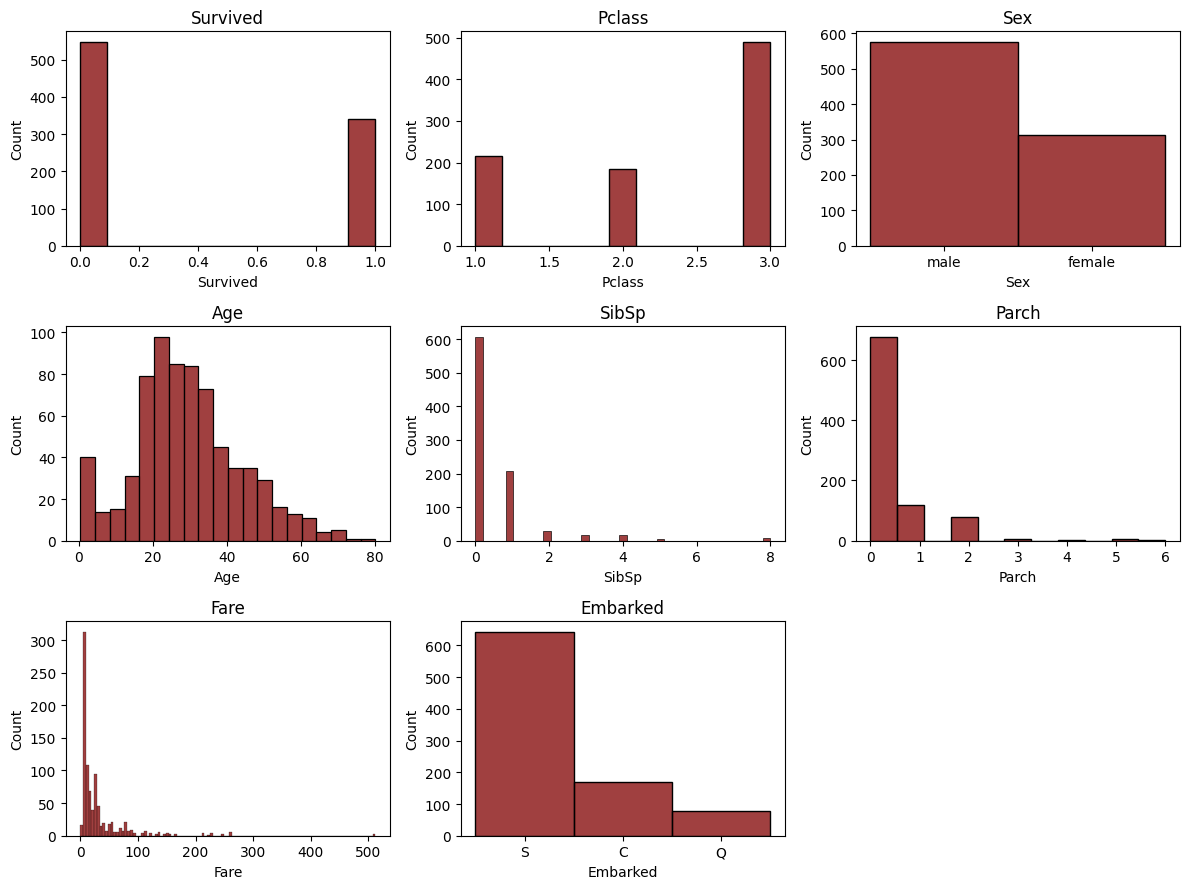

In [9]:
visual_data = train_df.drop(['Ticket' ,'Name'  , 'Cabin'] , axis = 1)

num_cols = len(visual_data.columns)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))
axes = axes.flatten()

for i, column in enumerate(visual_data.columns):
    ax = axes[i]
    sns.histplot(visual_data[column], ax=ax, color = "maroon")
    ax.set_title(column)

for i in range(num_cols, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Data Preprocessing

### Clean up and Removing useless features

In [10]:
def preprocess(df):

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        return x.split(" ")[-1]

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])


    train_df["Ticket_number"] = train_df["Ticket"].apply(ticket_number)
    train_df["Ticket_item"] = train_df["Ticket"].apply(ticket_item)
    test_df["Ticket_number"] = test_df["Ticket"].apply(ticket_number)
    test_df["Ticket_item"] = test_df["Ticket"].apply(ticket_item)

    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

train_df = train_df.drop(['Name' ,'Ticket'] , axis = 1) # Ticket replaced with Ticket_number and Ticket item
test_df = test_df.drop(['Name' ,'Ticket'] , axis = 1) # Ticket replaced with Ticket_number and Ticket item

train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,0,3,male,22.0,1,0,7.2500,NaN,S,21171,A/5
1,1,1,female,38.0,1,0,71.2833,C85,C,17599,PC
2,1,3,female,26.0,0,0,7.9250,NaN,S,3101282,STON/O2.
3,1,1,female,35.0,1,0,53.1000,C123,S,113803,NONE
4,0,3,male,35.0,0,0,8.0500,NaN,S,373450,NONE


In [11]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Ticket_number,Ticket_item
0,3,male,34.5,0,0,7.8292,NaN,Q,0,330911,NONE
1,3,female,47.0,1,0,7.0000,NaN,S,1,363272,NONE
2,2,male,62.0,0,0,9.6875,NaN,Q,0,240276,NONE
3,3,male,27.0,0,0,8.6625,NaN,S,0,315154,NONE
4,3,female,22.0,1,1,12.2875,NaN,S,1,3101298,NONE


## Missing values

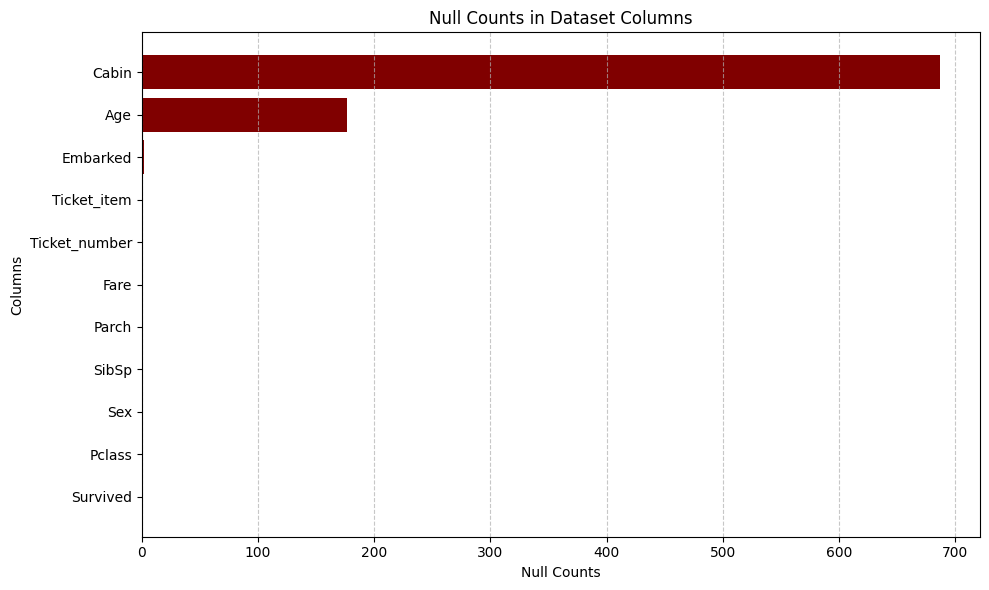

In [12]:
null_count_columns = train_df.isnull().sum()

null_counts_df = pd.DataFrame(list(null_count_columns.items()), columns=["Column", "NullCount"])

null_counts_df.sort_values(by="NullCount", inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(null_counts_df["Column"], null_counts_df["NullCount"], color="maroon")
plt.xlabel("Null Counts")
plt.ylabel("Columns")
plt.title("Null Counts in Dataset Columns")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

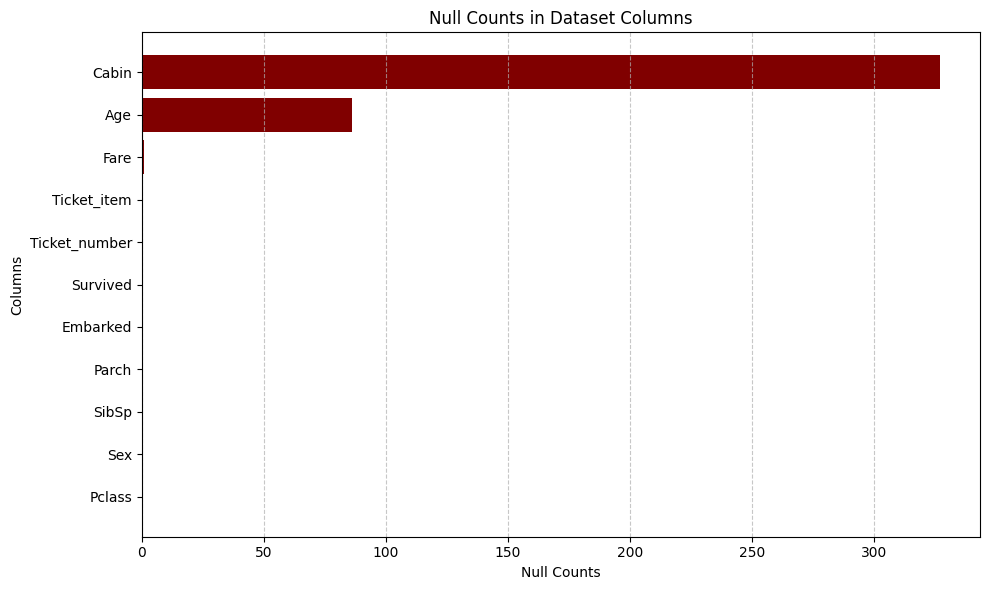

In [13]:
null_count_columns = test_df.isnull().sum()

null_counts_df = pd.DataFrame(list(null_count_columns.items()), columns=["Column", "NullCount"])

null_counts_df.sort_values(by="NullCount", inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(null_counts_df["Column"], null_counts_df["NullCount"], color="maroon")
plt.xlabel("Null Counts")
plt.ylabel("Columns")
plt.title("Null Counts in Dataset Columns")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
# At first 'Cabin' column should drop from dataset because of 70% missing values
train_df = train_df.drop(['Cabin'] , axis = 1)
test_df = test_df.drop(['Cabin'] , axis = 1)

# I want to use simple imputers to fill nan values for Age and Fare and Embarked
imp = SimpleImputer(strategy = 'mean')
train_df[['Age', 'Fare']] = imp.fit_transform(train_df[['Age', 'Fare']])
train_df[['Age', 'Fare']] = pd.DataFrame(train_df[['Age', 'Fare']] , columns = ['Age' , 'Fare'])

test_df[['Age', 'Fare']] = imp.fit_transform(test_df[['Age', 'Fare']])
test_df[['Age', 'Fare']] = pd.DataFrame(test_df[['Age', 'Fare']] , columns = ['Age' , 'Fare'])

imp = SimpleImputer(strategy = 'most_frequent')
train_df[['Embarked']] = imp.fit_transform(train_df[['Embarked']])
train_df[['Embarked']] = pd.DataFrame(train_df[['Embarked']] , columns = ['Embarked'])

test_df[['Embarked']] = imp.fit_transform(test_df[['Embarked']])
test_df[['Embarked']] = pd.DataFrame(test_df[['Embarked']] , columns = ['Embarked'])

train_df.head(7)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,0,3,male,22.000000,1,0,7.2500,S,21171,A/5
1,1,1,female,38.000000,1,0,71.2833,C,17599,PC
2,1,3,female,26.000000,0,0,7.9250,S,3101282,STON/O2.
3,1,1,female,35.000000,1,0,53.1000,S,113803,NONE
4,0,3,male,35.000000,0,0,8.0500,S,373450,NONE
5,0,3,male,29.699118,0,0,8.4583,Q,330877,NONE
6,0,1,male,54.000000,0,0,51.8625,S,17463,NONE


In [15]:
test_df.head(7)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Ticket_number,Ticket_item
0,3,male,34.5,0,0,7.8292,Q,0,330911,NONE
1,3,female,47.0,1,0,7.0000,S,1,363272,NONE
2,2,male,62.0,0,0,9.6875,Q,0,240276,NONE
3,3,male,27.0,0,0,8.6625,S,0,315154,NONE
4,3,female,22.0,1,1,12.2875,S,1,3101298,NONE
5,3,male,14.0,0,0,9.2250,S,0,7538,NONE
6,3,female,30.0,0,0,7.6292,Q,1,330972,NONE


In [16]:
train_df.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Ticket_number    0
Ticket_item      0
dtype: int64

In [17]:
test_df.isnull().sum()

Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Survived         0
Ticket_number    0
Ticket_item      0
dtype: int64

### Categorical data

In [18]:
# we have lots of categorical features so before using iterative imputer its better to encode nominal and ordinal categorical data
nominals = ['Sex' , 'Embarked' ,"Ticket_item"]
ordinals = ['Pclass' , "Parch" , "SibSp"] # values are numeric and meaningful so there is no need to encode

# we want to use LabelEncoding for nominal values
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
train_df['Embarked'] = le.fit_transform(train_df['Embarked'])
train_df['Ticket_item'] = le.fit_transform(train_df['Ticket_item'])

test_df['Sex'] = le.fit_transform(test_df['Sex'])
test_df['Embarked'] = le.fit_transform(test_df['Embarked'])
test_df['Ticket_item'] = le.fit_transform(test_df['Ticket_item'])

#Ticket_number column is defined as an object type so we need to convert its type to int or float
train_df['Ticket_number'] = pd.to_numeric(train_df['Ticket_number'], errors='coerce')
test_df['Ticket_number'] = pd.to_numeric(test_df['Ticket_number'], errors='coerce')

train_df.head(7)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,0,3,1,22.000000,1,0,7.2500,2,21171.0,4
1,1,1,0,38.000000,1,0,71.2833,0,17599.0,18
2,1,3,0,26.000000,0,0,7.9250,2,3101282.0,37
3,1,1,0,35.000000,1,0,53.1000,2,113803.0,16
4,0,3,1,35.000000,0,0,8.0500,2,373450.0,16
5,0,3,1,29.699118,0,0,8.4583,1,330877.0,16
6,0,1,1,54.000000,0,0,51.8625,2,17463.0,16


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Sex            891 non-null    int64  
 3   Age            891 non-null    float64
 4   SibSp          891 non-null    int64  
 5   Parch          891 non-null    int64  
 6   Fare           891 non-null    float64
 7   Embarked       891 non-null    int64  
 8   Ticket_number  887 non-null    float64
 9   Ticket_item    891 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Sex            418 non-null    int64  
 2   Age            418 non-null    float64
 3   SibSp          418 non-null    int64  
 4   Parch          418 non-null    int64  
 5   Fare           418 non-null    float64
 6   Embarked       418 non-null    int64  
 7   Survived       418 non-null    int64  
 8   Ticket_number  418 non-null    int64  
 9   Ticket_item    418 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 32.8 KB


**There is no categorical value left now we can go for outliers**

# Outliers

In [21]:
train_df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.870000e+02,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.536476,2.983284e+05,16.922559
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.791503,6.576144e+05,6.064231
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,3.000000e+00,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,1.487900e+04,16.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,2.000000,1.122770e+05,16.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,3.470820e+05,16.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,3.101317e+06,43.000000


In [22]:
test_df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Ticket_number,Ticket_item
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000
mean,2.265550,0.636364,30.272590,0.447368,0.392344,35.627188,1.401914,0.363636,2.534044e+05,15.327751
std,0.841838,0.481622,12.634534,0.896760,0.981429,55.840500,0.854496,0.481622,5.876873e+05,4.499427
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,1.000000,0.000000,1.350800e+04,15.000000
50%,3.000000,1.000000,30.272590,0.000000,0.000000,14.454200,2.000000,0.000000,3.560950e+04,15.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,2.000000,1.000000,3.455002e+05,15.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000,1.000000,3.101315e+06,34.000000


In [23]:
threshold = 3
# identify outliers using z-score method

# Calculate the z-scores for each data point
z_scores = np.abs((train_df - train_df.mean()) / train_df.std())

# outliers by filtering based on the z-scores
outliers = z_scores > threshold

# Now 'no_outliers' contains the data without outliers
outliers.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [24]:
threshold = 3
# identify outliers using z-score method

# Calculate the z-scores for each data point
z_scores = np.abs((test_df - test_df.mean()) / test_df.std())

# outliers by filtering based on the z-scores
outliers = z_scores > threshold

# Now 'no_outliers' contains the data without outliers
outliers.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Ticket_number,Ticket_item
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False


In [25]:
# removing outliers using z-score method

# Calculate the z-scores for each train point
z_scores = np.abs((train_df - train_df.mean()) / train_df.std())

# Remove outliers by filtering based on the z-scores
train_df = train_df[(z_scores <= threshold)]


# Calculate the z-scores for each test point
z_scores = np.abs((test_df - test_df.mean()) / test_df.std())

# Remove outliers by filtering based on the z-scores
test_df = test_df[(z_scores <= threshold)]


train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,0,3,1,22.0,1.0,0.0,7.2500,2,21171.0,4.0
1,1,1,0,38.0,1.0,0.0,71.2833,0,17599.0,18.0
2,1,3,0,26.0,0.0,0.0,7.9250,2,NaN,NaN
3,1,1,0,35.0,1.0,0.0,53.1000,2,113803.0,16.0
4,0,3,1,35.0,0.0,0.0,8.0500,2,373450.0,16.0


In [26]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Ticket_number,Ticket_item
0,3,1,34.5,0.0,0.0,7.8292,1,0,330911.0,15.0
1,3,0,47.0,1.0,0.0,7.0000,2,1,363272.0,15.0
2,2,1,62.0,0.0,0.0,9.6875,1,0,240276.0,15.0
3,3,1,27.0,0.0,0.0,8.6625,2,0,315154.0,15.0
4,3,0,22.0,1.0,1.0,12.2875,2,1,NaN,15.0


In [27]:
train_df.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age               7
SibSp            30
Parch            15
Fare             20
Embarked          0
Ticket_number    48
Ticket_item      39
dtype: int64

In [28]:
test_df.isnull().sum()

Pclass            0
Sex               0
Age               1
SibSp             7
Parch             6
Fare             18
Embarked          0
Survived          0
Ticket_number    16
Ticket_item      13
dtype: int64

In [29]:
# I want to drop NaN values because they are not too much
train_df = train_df.dropna()
test_df = test_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       763 non-null    int64  
 1   Pclass         763 non-null    int64  
 2   Sex            763 non-null    int64  
 3   Age            763 non-null    float64
 4   SibSp          763 non-null    float64
 5   Parch          763 non-null    float64
 6   Fare           763 non-null    float64
 7   Embarked       763 non-null    int64  
 8   Ticket_number  763 non-null    float64
 9   Ticket_item    763 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 65.6 KB


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         361 non-null    int64  
 1   Sex            361 non-null    int64  
 2   Age            361 non-null    float64
 3   SibSp          361 non-null    float64
 4   Parch          361 non-null    float64
 5   Fare           361 non-null    float64
 6   Embarked       361 non-null    int64  
 7   Survived       361 non-null    int64  
 8   Ticket_number  361 non-null    float64
 9   Ticket_item    361 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 31.0 KB


# Splitting to test , validation set

In [31]:
# Train set is ok to be trained on our models but we need validation so we are going to split test set to test and validation set
X_train = train_df.drop('Survived' , axis =1)
y_train = train_df['Survived']

test_df_X = test_df.drop('Survived' , axis =1)
test_df_y = test_df['Survived']

X_test ,X_val ,y_test ,y_val = train_test_split( test_df_X , test_df_y , test_size = 0.5 ,random_state =42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape,"\n")

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape,"\n")

print("X_test validation:", X_val.shape)
print("y_test validation:", y_val.shape)

X_train shape: (763, 9)
y_train shape: (763,) 

X_test shape: (180, 9)
y_test shape: (180,) 

X_test validation: (181, 9)
y_test validation: (181,)


# Data transformation

In [32]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train) , columns = X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val) , columns = X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test) , columns = X_test.columns)

In [33]:
X_train.head(7)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number,Ticket_item
0,0.875585,0.733694,-0.640850,1.061578,-0.460194,-0.645852,0.612381,-0.888453,-3.148821
1,-1.523235,-1.362967,0.656100,1.061578,-0.460194,1.457767,-1.866382,-0.912241,0.590557
2,-1.523235,-1.362967,0.412922,1.061578,-0.460194,0.860410,0.612381,-0.271566,0.056360
3,0.875585,0.733694,0.412922,-0.568169,-0.460194,-0.619571,0.612381,1.457566,0.056360
4,0.875585,0.733694,-0.016764,-0.568169,-0.460194,-0.606157,-0.627000,1.174049,0.056360
5,-1.523235,0.733694,1.953051,-0.568169,-0.460194,0.819755,0.612381,-0.913146,0.056360
6,0.875585,0.733694,-2.262039,4.321072,1.313180,-0.191674,0.612381,1.300793,0.056360


# Correlation

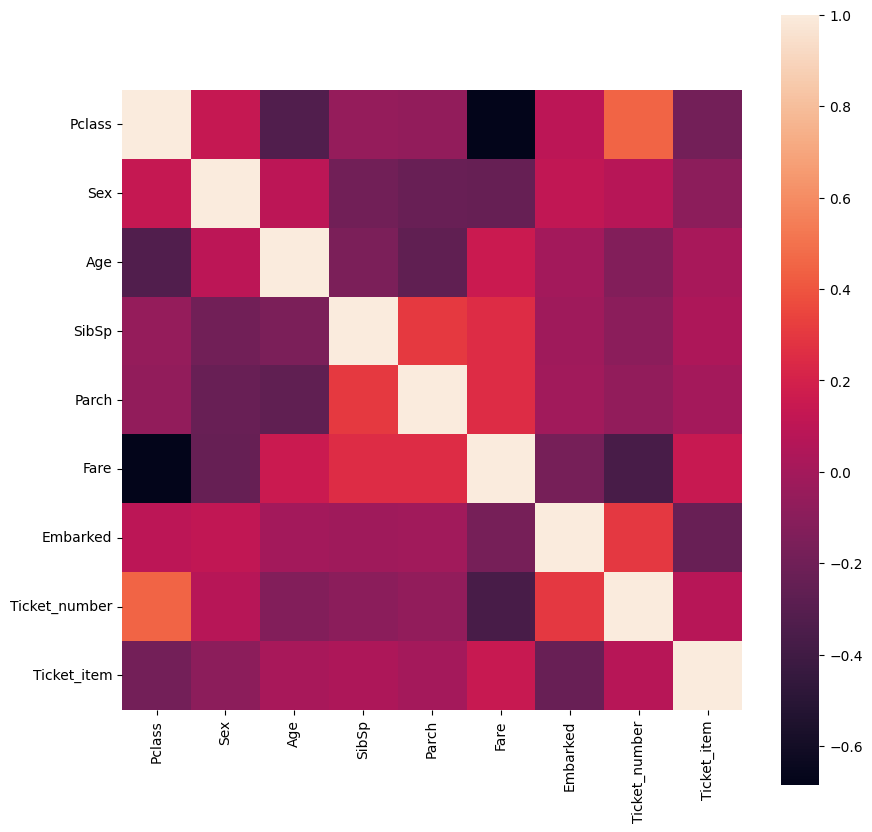

In [34]:
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax= 1, square=True);

# Feature Selection

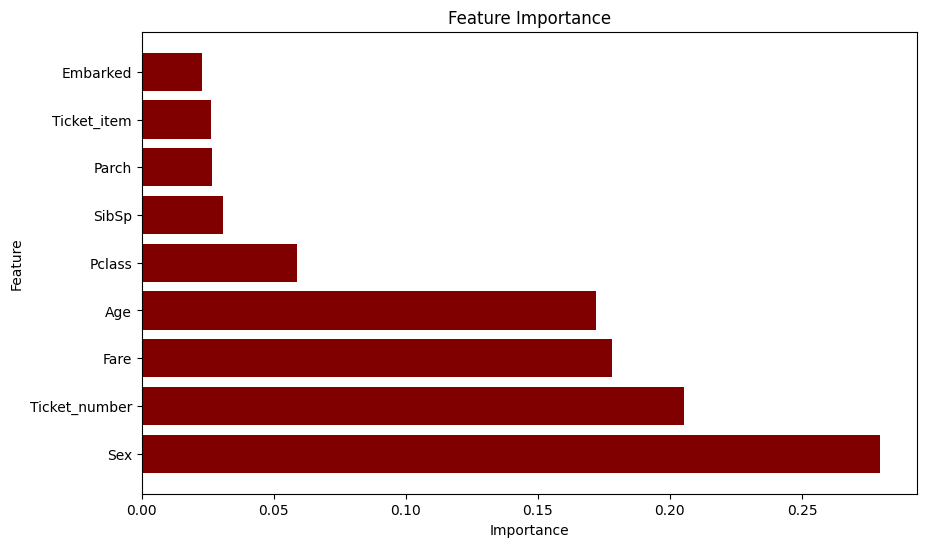

In [35]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_importances = model.feature_importances_

importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6) ,)
plt.barh(importances_df['Feature'], importances_df['Importance'] , color = 'Maroon')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

All features are important and there is no need to drop any of them

# Imbalanced Data

In [36]:
y_train.value_counts()

0    459
1    304
Name: Survived, dtype: int64

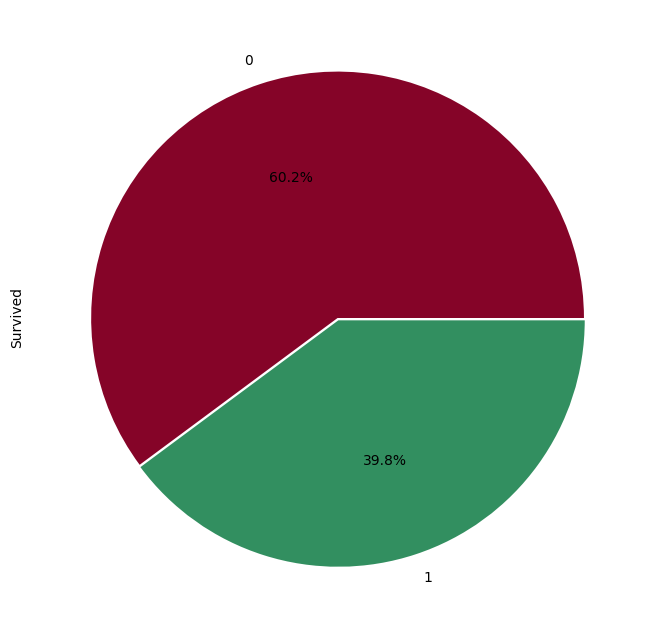

In [37]:
f,ax=plt.subplots(1,1,figsize=(12,8))
y_train.value_counts().plot.pie(explode=[0,0.01],autopct='%1.1f%%',shadow=False , colors = ['#850428','#328f60'])
plt.show()

In [38]:
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
y_train.value_counts()

0    459
1    459
Name: Survived, dtype: int64

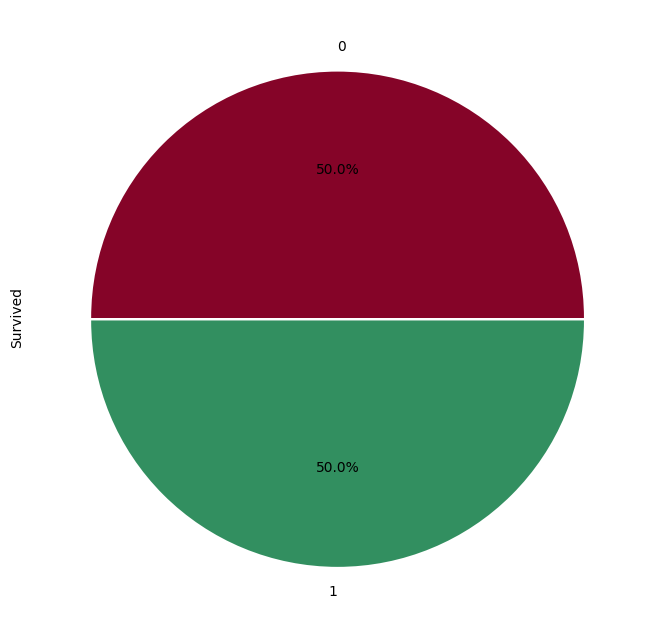

In [39]:
f,ax=plt.subplots(1,1,figsize=(12,8))
y_train.value_counts().plot.pie(explode=[0,0.01],autopct='%1.1f%%',shadow=False , colors = ['#850428','#328f60'])
plt.show()

Finally we did Preprocessing on our dataset. Now its the time to Model our data with Neural Network

# Modeling with Neural Network

In [40]:
tf.random.set_seed(42)

def create_model(hidden_units=128, dropout_rate=0.2):
    model = Sequential()
    input_shape = X_train.shape[1]

    model.add(Dense(units=hidden_units, input_shape=(input_shape,), activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=256, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=512, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=256, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train , y_train ,
          validation_data = (X_val , y_val) ,
          epochs = 200 ,
          batch_size = 64,
          verbose = 0) # verbose = 0 ====> in order to hide training steps and just show the steps


    loss , accuracy = model.evaluate(X_test , y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    return model

# Tunning hyperparameters

In [53]:
# Define hyperparameters to tune
param_grid = {
    'hidden_units': [64, 128 , 256 , 512 ],
    'dropout_rate': [0.2, 0.3, 0.4]
}

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

# Create your Keras classifier
keras_classifier = KerasClassifier(build_fn=create_model)

# Create StratifiedKFold cross-validation object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=4)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

ModuleNotFoundError: ignored

In [47]:
tf.random.set_seed(42)

def create_model(hidden_units=128, dropout_rate=0.2):
    model = Sequential()
    input_shape = X_train.shape[1]

    model.add(Dense(units=hidden_units, input_shape=(input_shape,), activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=256, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=512, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=256, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train , y_train ,
          validation_data = (X_val , y_val) ,
          epochs = 200 ,
          batch_size = 64,
          verbose = 0) # verbose = 0 ====> in order to hide training steps and just show the steps


    loss , accuracy = model.evaluate(X_test , y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    return model

create_model(hidden_units=512, dropout_rate=0.2)

6/6 [==============================] - 0s 4ms/step - loss: 1.1965 - accuracy: 0.8333
Test Loss: 1.1964527368545532, Test Accuracy: 0.8333333134651184
